# **Project in Computer Science:**
# **Identifying and Categorizing Offensive Language in Social Media (OffensEval)**
# **Example 1: Training the LSTM model**


## **First steps**

The next cell, imports the *keras* module that will be essential to run the code.

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.5'

For the project, the code was run using Google CoLab. It is recommended to run the code using CoLab, due to the high computational cost that the program requires. Then, it is necessary to import the directory where the dataset is stored on the drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


The next cell imports all the necessary modules to run the program.

In [0]:
# IMPORT MODULES
import numpy as np 
import re
import pandas as pd 

from keras.models import Sequential, Model
from keras.layers import Dense, SimpleRNN, Embedding, concatenate, Input, LSTM, SpatialDropout1D, Dropout, GRU, Bidirectional, Flatten, Conv1D, GlobalMaxPooling1D, Convolution1D, MaxPooling1D, AveragePooling1D, Concatenate, Activation 
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In the cell bellow, all the necessary constants of the program are initialized. NOTE that the files path should be set.

In [0]:
# INITIALIZATION
train_file = 'drive/My Drive/Dataset/olid-training-v1.0.tsv' # set corresponding path for the train dataset file
test_file = 'drive/My Drive/Dataset/testset-levela.tsv' # set corresponding path for the test dataset file
test_labels_a = 'drive/My Drive/Dataset/labels-levela.csv' # set corresponding path for the labels of the test dataset file

models = list() # used to save all the models
ensemble_model = list() # used to ensemble models

maxlen = 200
max_fatures = 10000

# GloVe Pretrained Embeddings
embedding_dim = 200

## **Data preprocessing**

The data preprocessing is applied at the cell bellow. The techniques applied are:
- Remove all the special characters and instances of USER and URL.
- Split the hashtag into words.
- Lowercase all the tweets.
- Tokenization.

NOTE that in this cell, the train dataset is split into a train and validation dataset. The validation dataset is the 10% of the original train dataset.


In [5]:
# DATA PREPROCESSING

# SPLIT HASHTAG INTO WORDS UTIL FUNCTIONS
def replace_hashtag(tweet):
  hashtags = find_hashtag(tweet)
  for hashtag in hashtags:
    split = split_hashtag(hashtag)
    tweet = tweet.replace(hashtag, split)
  tweet = tweet.replace('#', '')
  return tweet

def find_hashtag(tweet):
  hashtags = re.findall(r"#(\w+)", tweet)
  return hashtags

def split_hashtag(hashtag):
  fo = re.compile(r'#[A-Z]{2,}(?![a-z])|[A-Z][a-z]+')
  fi = fo.findall(hashtag)
  result = ''
  for var in fi:
    result += var + ' '
  return result

# IMPORT DATASET
data = pd.read_csv(train_file, sep='\t', header=0)
data = data[['id','tweet', 'subtask_a']]

# DATA PREPROCESSING
# split hashtags into words
for i, j in data.iterrows():
  data.at[i,'tweet'] = replace_hashtag(j['tweet'])

data['tweet'] = data['tweet'].apply(lambda x: x.lower()) # lowercase
data['tweet'] = data['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) # remove special characters
data['tweet'] = data['tweet'].str.replace('user','') # remove 'user' tokens
data['tweet'] = data['tweet'].str.replace('url','') # remove 'url' tokens

# REAL TEST DATASET
data_test = pd.read_csv(test_file, sep='\t', header=0)

# DATA PREPROCESSING
# split hashtags into words
for i, j in data_test.iterrows():
  data_test.at[i,'tweet'] = replace_hashtag(j['tweet'])

data_test['tweet'] = data_test['tweet'].apply(lambda x: x.lower()) # lowercase
data_test['tweet'] = data_test['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) # remove special characters
data_test['tweet'] = data_test['tweet'].str.replace('user','') # remove 'user' tokens
data_test['tweet'] = data_test['tweet'].str.replace('url','') # remove 'url' tokens

labels_test = pd.read_csv(test_labels_a, sep=',', header=0)
labels_test = labels_test[['id','subtask_a']]
data_test = pd.merge(data_test, labels_test, on='id')

# TOKENIZER
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['tweet'].values)
X = tokenizer.texts_to_sequences(data['tweet'].values)
X = pad_sequences(X, maxlen=maxlen)
Y = pd.get_dummies(data['subtask_a']).values

# Testing with validation dataset
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)

# Testing with original test dataset
X_test_real = tokenizer.texts_to_sequences(data_test['tweet'].values)
X_test_real = pad_sequences(X_test_real, maxlen=maxlen)
Y_test_real = pd.get_dummies(data_test['subtask_a']).values

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
print(X_test_real.shape,Y_test_real.shape)


(11916, 200) (11916, 2)
(1324, 200) (1324, 2)
(860, 200) (860, 2)


## **Pre-trained word embeddings**

In the next cell, the pre-trained word embeddings are loaded, and the embedding matrix is obtained. NOTE that the file path for the embeddings has to be set.

In [6]:
# PRETRAINED EMBEDDINGS

#embedding_file = open('drive/My Drive/embeddings/glove.6B.100d.txt') # 100-dimensional pre-trained word embeddings - set the file path
embedding_file = open('drive/My Drive/embeddings/glove.6B.200d.txt') # 200-dimensional pre-trained word embeddings - set the file path

embeddings_index = {}

for line in embedding_file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
embedding_file.close()

print('Found %s word vectors.' % len(embeddings_index))

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index)) 

embedding_matrix = np.zeros((max_fatures, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_fatures:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

Found 400000 word vectors.
Found 19501 unique tokens.


## **Training Deep Learning models**

The following cells are divided into the different deep learning models (each cell initializes a different model). 

NOTE that you can run only one of these cells each time to evaluate a different model.

### SimpleRNN

In [0]:
# Simple RNN
model_name = 'Simple RNN'

model = Sequential()
#model.add(Embedding(max_fatures, embedding_dim,input_length = maxlen)) # without pretrained embeddings
model.add(Embedding(max_fatures, embedding_dim, weights = [embedding_matrix], input_length=maxlen, trainable=True)) # with pretrained embeddings
model.add(SimpleRNN(32))
model.add(Dense(2, activation='softmax'))

print('Model ' + model_name + ' has been initialized.')

### Simple LSTM

In [0]:
# Simple LSTM
model_name = 'Simple LSTM'

model = Sequential()
#model.add(Embedding(max_features, 32)) # without pretrained embeddings
model.add(Embedding(max_fatures, embedding_dim, weights = [embedding_matrix], input_length=maxlen, trainable=True)) # with pretrained embeddings
model.add(LSTM(32))
model.add(Dense(2, activation='softmax'))

print('Model ' + model_name + ' has been initialized.')

### LSTM

In [8]:
# LSTM
model_name = 'LSTM'

lstm_out = 196

model = Sequential()
#model.add(Embedding(max_fatures, embedding_dim,input_length = maxlen)) # without pretrained embeddings
model.add(Embedding(max_fatures, embedding_dim, weights = [embedding_matrix], input_length=maxlen, trainable=True)) # with pretrained embeddings
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))

print('Model ' + model_name + ' has been initialized.')

Model LSTM has been initialized.


### BiLSTM + DROPOUT

In [0]:
# BILSTM + DROPOUT
model_name = 'BILSTM + DROPOUT'

lstm_out = 196

model = Sequential()
#model.add(Embedding(max_fatures, embedding_dim, input_length = maxlen, trainable = True)) #without pretrained embeddings
model.add(Embedding(max_fatures, embedding_dim, weights = [embedding_matrix], input_length=maxlen, trainable=True)) #with pretrained embeddings
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(lstm_out, return_sequences=True, recurrent_dropout=0.25)))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(lstm_out, return_sequences=True, recurrent_dropout=0.25)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(2,activation='softmax'))

print('Model ' + model_name + ' has been initialized.')

### CNN + GLOBAL MAX POOLING

In [0]:
# CNN + GLOBAL MAX POOLING
model_name = 'CNN + GLOBAL MAX POOLING'

model = Sequential()
#model.add(Embedding(max_fatures, embedding_dim, input_length = maxlen, trainable = False)) #without pretrained embeddings
model.add(Embedding(max_fatures, embedding_dim, weights = [embedding_matrix], input_length=maxlen, trainable=True)) #with pretrained embeddings
model.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

print('Model ' + model_name + ' has been initialized.')

### CNN (3 filters)

In [0]:
# CNN (3 filters)
model_name = 'CNN'

embedding_dim = 200

i = Input(shape=(maxlen,), dtype='int32', name='main_input')
x = Embedding(max_fatures, embedding_dim ,weights = [embedding_matrix], input_length=maxlen, trainable=True)(i)
x = Dropout(0.4)(x)

def get_conv_pool(x_input, max_len, sufix, n_grams=[2,3,4], feature_maps=256):
      branches = []
      for n in n_grams:
          branch = Conv1D(filters=feature_maps, kernel_size=n, activation='relu', name='Conv_'+sufix+'_'+str(n))(x_input)
          branch = MaxPooling1D(pool_size=max_len-n+1, strides=None, padding='valid', name='MaxPooling_'+sufix+'_'+str(n))(branch)
          branch = Flatten(name='Flatten_'+sufix+'_'+str(n))(branch)
          branches.append(branch)
      return branches

branches = get_conv_pool(x, maxlen, 'dynamic')
z = concatenate(branches, axis=-1)
z1 = Dropout(0.3)(z)
z2 = Dense(256, activation='relu')(z1)
o = Dense(2, activation='softmax')(z2)

model = Model(inputs=i, outputs=o)

print('Model ' + model_name + ' has been initialized.')

### BiLSTM + BiGRU

In [0]:
# BILSTM + BIGRU
model_name = 'BILSTM + BIGRU'

lstm_units = 196
gru_units = 64

i = Input(shape=(maxlen,), dtype='int32', name='main_input')
x = Embedding(max_fatures, embedding_dim, weights = [embedding_matrix], input_length=maxlen, trainable=True)(i)
x = Dropout(0.4)(x)
x1 = Bidirectional(LSTM(lstm_units, return_sequences=True, recurrent_dropout=0.3))(x)
x2 = Dropout(0.3)(x1)
x3 = Bidirectional(GRU(gru_units, return_sequences=True))(x2)
x4 = Dropout(0.3)(x3)

max_pooling = MaxPooling1D()(x4)
max_pooling = Flatten()(max_pooling)

average_pooling = AveragePooling1D()(x4)
average_pooling = Flatten()(average_pooling)

z1 = concatenate([max_pooling, average_pooling], axis=-1)
z2 = Dense(128, activation='relu')(z1)
o = Dense(2, activation='softmax')(z2)

model = Model(inputs=i, outputs=o)

print('Model ' + model_name + ' has been initialized.')

## **Evaluating deep learning models**

The following code has to be run each time you want to fit and evaluate a different model.

### Compiling the model

In [0]:
# COMPILE MODEL
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

### Ploting the model scheme

Model: LSTM
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 200)          2000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 200)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               311248    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 394       
Total params: 2,311,642
Trainable params: 2,311,642
Non-trainable params: 0
_________________________________________________________________
None


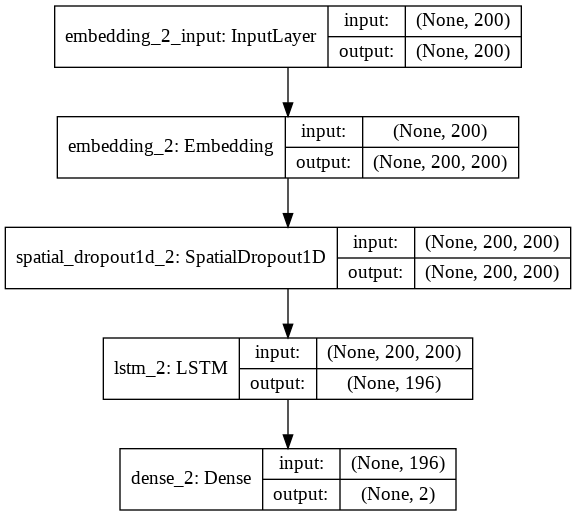

In [11]:
# MODEL SCHEME
print('Model:', model_name)

print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

### Fitting the model

In [12]:
# FIT THE MODEL
print('Model:', model_name)

batch_size = 128
model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size)

Model: LSTM
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
11916/11916 [==============================] - 194s 16ms/step - loss: 0.5917 - acc: 0.6939
Epoch 2/10
11916/11916 [==============================] - 185s 16ms/step - loss: 0.5271 - acc: 0.7435
Epoch 3/10
11916/11916 [==============================] - 143s 12ms/step - loss: 0.4707 - acc: 0.7785
Epoch 4/10
11916/11916 [==============================] - 141s 12ms/step - loss: 0.4393 - acc: 0.8025
Epoch 5/10
11916/11916 [==============================] - 139s 12ms/step - loss: 0.4143 - acc: 0.8140
Epoch 6/10
11916/11916 [==============================] - 139s 12ms/step - loss: 0.3840 - acc: 0.8306
Epoch 7/10
11916/11916 [==============================] - 138s 12ms/step - loss: 0.3578 - acc: 0.8455
Epoch 8/10
11916/11916 [==============================] - 138s 12ms/step - loss: 0.3255 - acc: 0.8609
Epoch 9/10
11916/11916 [==============================] - 139s 12ms/step - l

The cell bellow, saves the models and creates a list for ensembling different models. In our project, the ensemble combines the BiLSTM+BiGRU model and the CNN (3 filters) model. 

To try the embedded model you have to run first one of the two models and save them in the *ensemble_model* list and then run the second model and save it again in the list. Finally, the *ensemble_model* list will contain the two models you want to ensemble.

In [0]:
# SAVE THE MODEL TO A LIST
models.append(model) # save all the trained models

# Ensemble of CNN (3 filters) and BiLSTM+BiGRU
if model_name == 'BILSTM + BIGRU' or model_name == 'CNN': 
  ensemble_model.append(model)

### Prediction for only one model

Predict and plot the results of the prediction using the validation dataset and the test dataset. 

NOTE that you don't have to run this cell if you want to try an ensemble model.

In [17]:
# PREDICTION FOR ONE MODEL

# PREDICTION USING VALIDATION DATASET
print('Model:', model_name)
print('Model prediction with validation dataset:')

# Prediction for class Model
Y_pred = model.predict(X_test,batch_size = batch_size)
Y_pred = np.argmax(Y_pred,axis=1)

df_test = pd.DataFrame({'true': Y_test.tolist(), 'pred': Y_pred})
df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))

print("Confusion matrix:", confusion_matrix(df_test.true, df_test.pred))
print(classification_report(df_test.true, df_test.pred, digits=4))

# PREDICTION USING REAL TEST DATASET
print('Model:', model_name)
print('Model prediction with test dataset:')

# Prediction for class Model
Y_pred_real = model.predict(X_test_real,batch_size = batch_size)
Y_pred_real = np.argmax(Y_pred_real,axis=1)

df_test_real = pd.DataFrame({'true': Y_test_real.tolist(), 'pred':Y_pred_real})
df_test_real['true'] = df_test_real['true'].apply(lambda x: np.argmax(x))

print("Confusion matrix", confusion_matrix(df_test_real.true, df_test_real.pred))
print(classification_report(df_test_real.true, df_test_real.pred, digits=4))

Model: LSTM
Model prediction with validation dataset:
Confusion matrix: [[676 176]
 [145 327]]
              precision    recall  f1-score   support

           0     0.8234    0.7934    0.8081       852
           1     0.6501    0.6928    0.6708       472

    accuracy                         0.7576      1324
   macro avg     0.7367    0.7431    0.7394      1324
weighted avg     0.7616    0.7576    0.7592      1324

Model: LSTM
Model prediction with test dataset:
Confusion matrix [[535  85]
 [ 83 157]]
              precision    recall  f1-score   support

           0     0.8657    0.8629    0.8643       620
           1     0.6488    0.6542    0.6515       240

    accuracy                         0.8047       860
   macro avg     0.7572    0.7585    0.7579       860
weighted avg     0.8052    0.8047    0.8049       860



### Prediction for ensembling models.

Predict and plot the results of the prediction using the validation dataset and the test dataset.

In [0]:
# PREDICTION FOR ENSEMBLE MODELS

# PREDICTION USING VALIDATION DATASET
y_combine = [model.predict(X_test, batch_size = batch_size) for model in ensemble_model]
y_combine = np.array(y_combine)

# sum across ensembles
summed = np.sum(y_combine, axis=0)

# argmax across classes
Y_pred = np.argmax(summed, axis=1)

df_test = pd.DataFrame({'true': Y_test.tolist(), 'pred': Y_pred})
df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))

print("Confusion matrix:", confusion_matrix = confusion_matrix(df_test.true, df_test.pred))
print(classification_report(df_test.true, df_test.pred, digits=4))

# PREDICTION USING REAL TEST DATASET
y_combine = [model.predict(X_test_real, batch_size = batch_size) for model in ensemble_model]
y_combine = np.array(y_combine)

# sum across ensembles
summed = np.sum(y_combine, axis=0)

# argmax across classes
Y_pred_real = np.argmax(summed, axis=1)

df_test_real = pd.DataFrame({'true': Y_test_real.tolist(), 'pred':Y_pred_real})
df_test_real['true'] = df_test_real['true'].apply(lambda x: np.argmax(x))

print("Confusion matrix",confusion_matrix = confusion_matrix(df_test_real.true, df_test_real.pred))
print(classification_report(df_test_real.true, df_test_real.pred, digits=4))
